# Traffic Sign Recognition using convolutional network

This notebook implements a traffic sign recognition system using convolutional Network. It is based on a project realized during the first term of the Self-Driving Car Nanodegree of udacity.

---
## Loading The Data

The data use for this project are based on the [German traffic sign dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The data has already been processed and stored into three pickle files, one for training, one for validation and one for testing.

In [4]:
import numpy as np
import pandas as pd
import pickle
from scipy.misc import imread, imresize
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import cv2

# Visualizations will be shown in the notebook.
%matplotlib inline
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)

In [24]:
# Load pickled data
training_file = './data/train.p'
validation_file = './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = str(X_train.shape[1])+'x'+str(X_train.shape[2])+'x'+str(X_train.shape[3])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = 32x32x3
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

To explore the dataset, we will first count how many instance of each sign there is in each dataset (training, validation and test). This is done using pandas. 

In [4]:
count_train = pd.Series(y_train, name='train').value_counts()
count_valid = pd.Series(y_valid, name='valid').value_counts()
count_test = pd.Series(y_test, name='test').value_counts()
counts = pd.concat([count_train,count_valid,count_test],axis=1)
names = pd.read_csv('signnames.csv')
counts = pd.concat([counts, names['SignName']],axis=1).set_index('SignName')
counts.loc['Total']=[np.sum(counts['train']),np.sum(counts['test']),np.sum(counts['valid'])]
counts

,train,valid,test
SignName,,,
Speed limit (20km/h),180,30,60
Speed limit (30km/h),1980,240,720
Speed limit (50km/h),2010,240,750
Speed limit (60km/h),1260,150,450
Speed limit (70km/h),1770,210,660
Speed limit (80km/h),1650,210,630
End of speed limit (80km/h),360,60,150
Speed limit (100km/h),1290,150,450
Speed limit (120km/h),1260,150,450


In the training set, the most represented sign has 2010 example, while the least represented has 180 example. There is quite some imbalance between the different classes. Let us check if the distribution of traffic signs is more or less identical in each of the three datasets. To visualize this, we compute the proportion of each sign with respect to the total number of examples in each dataset, and use a barplot to compare them.

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


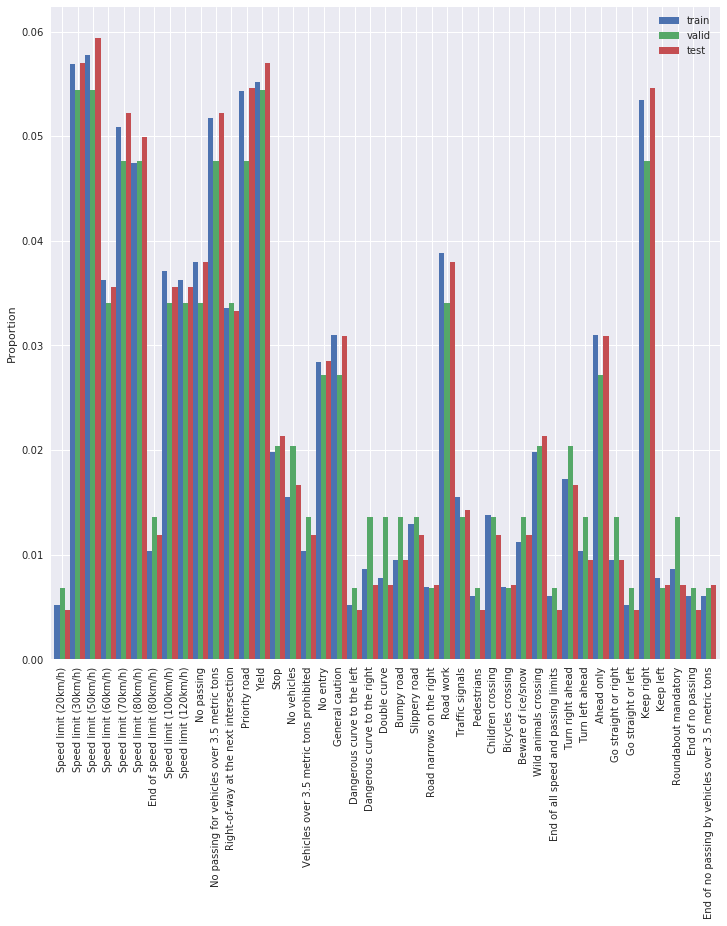

In [5]:
count_train = pd.Series(y_train, name='train').value_counts()/len(y_train)
count_valid = pd.Series(y_valid, name='valid').value_counts()/len(y_valid)
count_test = pd.Series(y_test, name='test').value_counts()/len(y_test)
counts = pd.concat([count_train,count_valid,count_test],axis=1)
#counts.reset_index(inplace=True)
mpl.rcParams['figure.figsize'] = (12,12)
ax=counts.plot(kind='bar',width=1.0)
ax.set_xticklabels(names['SignName'])
plt.ylabel('Proportion')

mpl.rcParams['figure.figsize'] = (6,6)

We can observe that in general, the training and test sets are more or less identically distributed, but the validation set is slightly different.

Let us pick some image at random to visualize it prior to any processing.

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


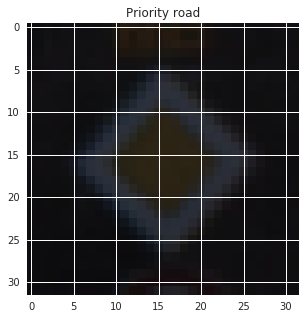

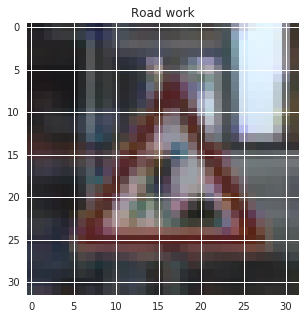

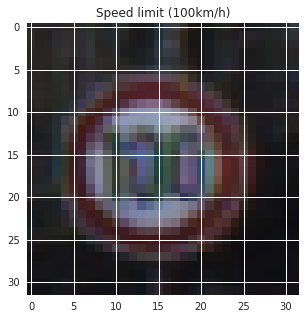

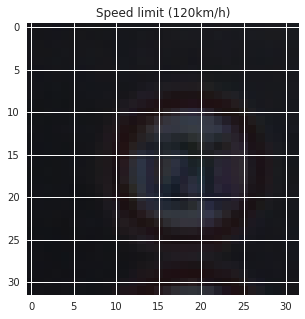

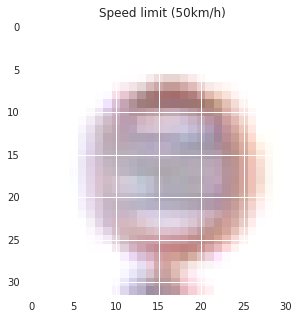

In [6]:
# Randomly visualize an image from the training set
# set figure size
mpl.rcParams['figure.figsize'] = (5,5)
np.random.seed(seed=1234)
n_img_to_show = 5
for i in np.random.randint(0,len(X_train),n_img_to_show):
    plt.figure()
    plt.imshow(X_train[i,:,:,:])
    plt.title(names.loc[y_train[i],'SignName'])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [25]:
# Here I set aside some images to illustrate the difference between original images and processed images.
np.random.seed(seed=467)
n_img_to_show = 5
test_imgs_idx = list(np.random.randint(0,len(X_train),n_img_to_show))
test_images_before = X_train[test_imgs_idx,:,:,:]

In [26]:
# pre-processing pipeline:
# 1) switch to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114]).reshape((rgb.shape[0],rgb.shape[1],rgb.shape[2],1))
# convert to grayscale
X_train = rgb2gray(X_train)
X_valid = rgb2gray(X_valid)
X_test = rgb2gray(X_test) 

In [27]:
# 2) Standardize each figure by substracting its mean and dividing by its output.
X_train = (X_train - np.mean(X_train,axis=(1,2),keepdims=True))/np.std(X_train,axis=(1,2),keepdims=1)
X_valid = (X_valid - np.mean(X_valid,axis=(1,2),keepdims=True))/np.std(X_valid,axis=(1,2),keepdims=1)
X_test = (X_test - np.mean(X_test,axis=(1,2),keepdims=True))/np.std(X_test,axis=(1,2),keepdims=1)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


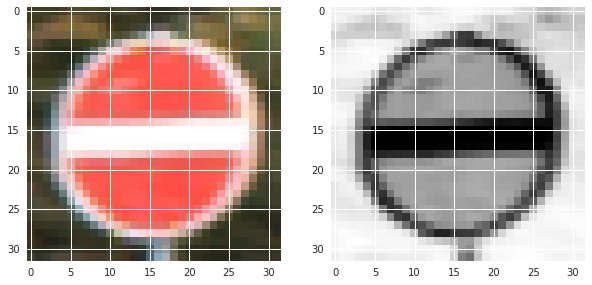

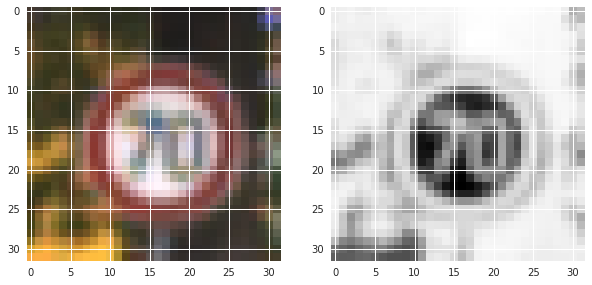

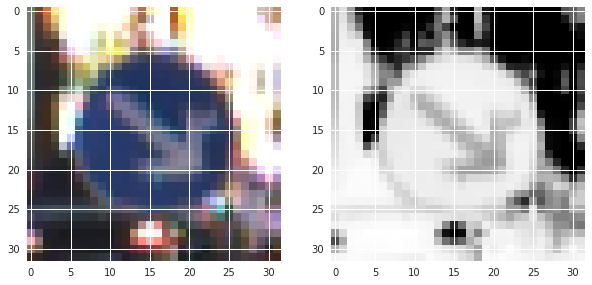

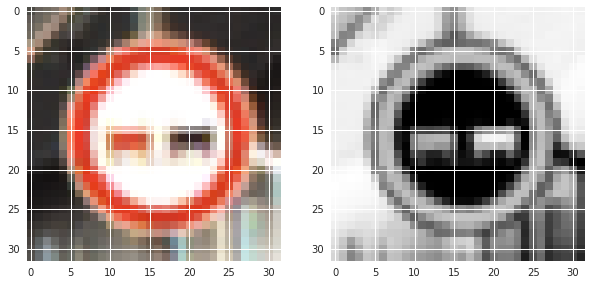

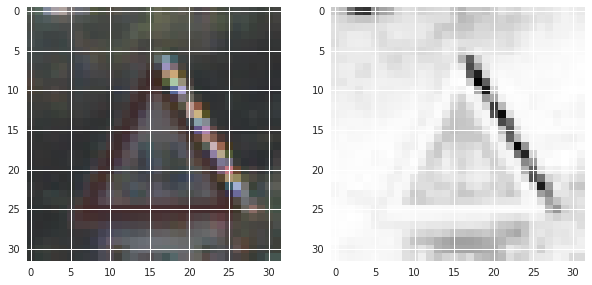

In [28]:
# Plot side by side the original and transformed images for the images we set aside previously
# set figure size
mpl.rcParams['figure.figsize'] = (10,5)
for i in range(n_img_to_show):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(test_images_before[i,:,:,:])
    ax2.imshow(X_train[test_imgs_idx[i],:,:,0])

### Model Architecture

Now we can define the network architecture. It goes as follows:

* Layer 1 : 
    - convolutional layer with patch size 5, stride 1 and valid padding. 
    - ReLu activation. 
    - dropout with keep probability =0.5
    - Input : 32x32x1 
    - Output : 28x28x16
* Layer 2 : 
    - convolutional layer with patch size 5, stride 1 and valid padding. 
    - ReLu activation. 
    - dropout with keep probability =0.5
    - max_pooling with patch size 5 and stride 2. 
    - Input : 28x28x16 
    - Output : 12x12x32
* Layer 3 : 
    - convolutional layer with patch size 5, stride 1 and valid padding. 
    - ReLu activation. 
    - dropout with keep probability =0.5
    - max_pooling with patch size 5 and stride 2. 
    - Input : 12x12x32
    - Output : 8x8x64 
* Layer 4 : 
    - fully connected layer with ReLu activation. 
    - Input : 1024x1 
    - Output : 256x1
* Layer 5 : 
    - Output layer, fully connected with softmax output. 
    - Input : 256x1 
    - Output : 43x1
    
The loss function is the cross-entropy. An $L_2$ regularization term with regularization parameter equal to $10^{-3}$ was added to reduce slightly overfitting. The optimization is achieved using AdamOptimizer with an initial learning rate of $5.10^{-3}$

In [39]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

graph = tf.Graph()

with graph.as_default():

    def LeNet(x, keep_prob, l2):    
        # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16. Activation = relu
        patch_size1 = 5
        num_channels1 = 1
        depth1 = 16
        stride1 = 1
        weights1 = tf.Variable(tf.truncated_normal([patch_size1, patch_size1, num_channels1, depth1], 
                                                   stddev=np.sqrt(2/(5*5*1))))
        biases1 = tf.Variable(tf.zeros([depth1]))
        conv1 = tf.nn.conv2d(x, weights1, [1, stride1, stride1, 1], padding='VALID')
        relu1 = tf.nn.relu(tf.add(conv1,biases1))
        # Layer 2: Convolutional. Output = 24x24x32. Activation = relu
        patch_size2 = 5
        num_channels2 = depth1
        depth2 = 32
        stride2 = 1
        weights2 = tf.Variable(tf.truncated_normal([patch_size2, patch_size2, num_channels2, depth2],
                                                   stddev=np.sqrt(2/(5*5*16))))
        biases2 = tf.Variable(tf.zeros([depth2]))
        conv2 = tf.nn.conv2d(relu1, weights2, [1, stride2, stride2, 1], padding='VALID')
        relu2 = tf.nn.relu(tf.add(conv2,biases2))
        # Pooling. Input = 24x24x32. Output = 12x12x32.
        pool2 = tf.nn.max_pool(relu2, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')

        # Layer 3: Convolutional. Output = 8x8x64. Activation = relu
        patch_size3 = 5
        num_channels3 = 32
        depth3 = 64
        stride3 = 1
        weights3 = tf.Variable(tf.truncated_normal([patch_size3, patch_size3, num_channels3, depth3],
                                                   stddev=np.sqrt(2/(5*5*32))))
        biases3 = tf.Variable(tf.zeros([depth3]))
        conv3 = tf.nn.conv2d(pool2, weights3, [1, stride3, stride3, 1], padding='VALID')
        relu3 = tf.nn.relu(tf.add(conv3,biases3))
        # Pooling. Input = 8x8x64. Output = 4x4*64
        pool3 = tf.nn.max_pool(relu3, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
 
        # TODO: Flatten. Input = 4x4x64. Output = 1024.
        flat = tf.nn.dropout(flatten(pool3),keep_prob)
        # TODO: Layer 4: Fully Connected. Input = 1024. Output = 256.
        weights4 = tf.Variable(tf.truncated_normal([1024,256], stddev=np.sqrt(2/(1024))))
        biases4 = tf.Variable(tf.zeros([256]))
        fully4 = tf.add(tf.matmul(flat,weights4),biases4)
        # Activation.
        relu4 = tf.nn.dropout(tf.nn.relu(fully4),keep_prob)
 
        # Layer 5: Fully Connected. Input = 256. Output = 128.
        weights5 = tf.Variable(tf.truncated_normal([256,43], stddev=np.sqrt(2/(256))))
        biases5 = tf.Variable(tf.zeros([43]))
        logits = tf.nn.dropout(tf.add(tf.matmul(relu4,weights5),biases5),keep_prob)

        l2_loss = l2*(tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights2)+tf.nn.l2_loss(weights3)
                      +tf.nn.l2_loss(weights4)+tf.nn.l2_loss(weights5))
        return logits, l2_loss

    x = tf.placeholder(tf.float32, (None, 32, 32, 1))
    y = tf.placeholder(tf.int32, (None))
    p = tf.placeholder(tf.float32,())
    one_hot_y = tf.one_hot(y, 43)

    rate = 0.0005
    l2 = 1e-3

    logits,l2_loss = LeNet(x, p, l2)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

    loss_operation = tf.reduce_mean(cross_entropy)+l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    #extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    #with tf.control_dependencies(extra_update_ops):
    training_operation = optimizer.minimize(loss_operation)

    # Accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # class probabilities
    #top5_classes = tf.nn.top_k(tf.nn.softmax(logits), k=5)
    
    saver = tf.train.Saver()

    
    init = tf.global_variables_initializer()

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

The network is trained on 15 epochs (i.e. passes over the entire training set), by batches of 64 training examples. After each epoch, we compute the accuracy of the classificaiton over the training and validation sets. Accuracy on the test set, is computed at the end of the process. 

The training was made on an AWS instance with GPU, which was pretty fast allowed several repetition for tuning the parameters.

Training...

EPOCH 1 ...
MiniBatch Accuracy = 0.723
Validation Accuracy = 0.694

EPOCH 2 ...
MiniBatch Accuracy = 0.936
Validation Accuracy = 0.855

EPOCH 3 ...
MiniBatch Accuracy = 0.979
Validation Accuracy = 0.934

EPOCH 4 ...
MiniBatch Accuracy = 0.979
Validation Accuracy = 0.967

EPOCH 5 ...
MiniBatch Accuracy = 1.000
Validation Accuracy = 0.973

EPOCH 6 ...
MiniBatch Accuracy = 1.000
Validation Accuracy = 0.975

EPOCH 7 ...
MiniBatch Accuracy = 0.957
Validation Accuracy = 0.983

EPOCH 8 ...
MiniBatch Accuracy = 1.000
Validation Accuracy = 0.978

EPOCH 9 ...
MiniBatch Accuracy = 1.000
Validation Accuracy = 0.979

EPOCH 10 ...
MiniBatch Accuracy = 1.000
Validation Accuracy = 0.982

EPOCH 11 ...
MiniBatch Accuracy = 1.000
Validation Accuracy = 0.983

EPOCH 12 ...
MiniBatch Accuracy = 1.000
Validation Accuracy = 0.986

EPOCH 13 ...
MiniBatch Accuracy = 1.000
Validation Accuracy = 0.988

EPOCH 14 ...
MiniBatch Accuracy = 1.000
Validation Accuracy = 0.985

EPOCH 15 ...
MiniBatch Accurac

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


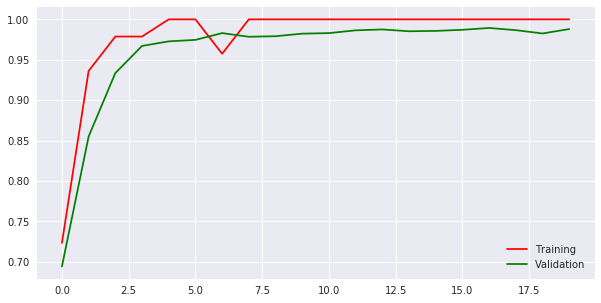

In [43]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
EPOCHS=20
BATCH_SIZE=64
KEEP_PROB = 0.4
train_accuracy = []
valid_accuracy = []
with tf.Session(graph=graph) as sess:
    sess.run(init)
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, p:KEEP_PROB})
        
        acc_t = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, p:1.0})
        acc_v = sess.run(accuracy_operation, feed_dict={x: X_valid, y: y_valid,p:1.0})
        print("EPOCH {} ...".format(i+1))
        print("MiniBatch Accuracy = {:.3f}".format(acc_t))
        print("Validation Accuracy = {:.3f}".format(acc_v))
        print()
        train_accuracy.append(acc_t)
        valid_accuracy.append(acc_v)
    saver.save(sess, './lenet')
    print("Model saved")
    
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, p:1.0})
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print()

plt.figure()
plt.plot(np.arange(EPOCHS),train_accuracy,'r',label='Training')
plt.plot(np.arange(EPOCHS),valid_accuracy,'g',label='Validation')
plt.legend()

At the end, we obtain an accuracy of .96 on the test set. The high accuracy on the training batches seems to indicate that there is still overfitting.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

I've chosen 7 images from the internet to test the network. The five first should be straightforward, as they all display neat traffic sign sign form the front. The last two are more tricky : one has a small traffic sign on a bigger image, and the other displays a sign slightly skewed by the position of the camera. Let us visualize these.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

## these images are located in the folder 'NewImages'.
fnames = ['./Newimages/sign'+str(i)+'.png' for i in range(1,8)]
mpl.rcParams['figure.figsize'] = (35,5)
f, ax = plt.subplots(1, 7)
for i,fname in enumerate(fnames):
    img = imread(fname)
    ax[i].imshow(img)

### Predict the Sign Type for Each Image

First we need to transform the images according to the same pre-processing scheme we used for the training set. Additionally, we need to rescale the images to the correct size (i.e. 32x32). 

In [ ]:
# Preprocessing pipeline :
# 0) Scale images to 32x32x3
# 1) switch to greyscale
# 2) standardize images
test_imgs = np.ndarray((7,32,32,1))
f, ax = plt.subplots(1, 7)
for i,fname in enumerate(fnames):
    img = imread(fname)
    img = imresize(img,(32,32)).reshape((1,32,32,3))
    img = rgb2gray(img)
    img = (img-np.mean(img,axis=(1,2),keepdims=True))/np.std(img,axis=(1,2),keepdims=True)
    test_imgs[i,:,:,:] = img
    ax[i].imshow(img[0,:,:,0])

Next we can use the graph above, and the weights computed during training to make predictions on the images. The network compute the logits of each image. The corresponding label is the argmax of the logits. 

In [ ]:
# Reload the model
with tf.Session(graph=graph) as sess:
    # Restore variables from disk.
    saver.restore(sess, "./lenet")
    # make the prediction:
    # compute logits from the network
    pred_score = sess.run(logits, feed_dict={x: test_imgs,p:1.0})
    # Compute argmax of logits
    pred = np.argmax(pred_score,axis=1)
    # convert argmax into traffice sign's label
    pred_label = [names.loc[i,'SignName'] for i in pred]


### Analyze Performance

We can compute the accuracy on this small dataset by comparing it to the correct label. 

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

# write down vector label
true_label = ['Stop', 'Speed limit (50km/h)', 'No entry', 'Right-of-way at the next intersection',
              'Wild animals crossing', 'Double curve', 'Speed limit (80km/h)']
# compute accuracy
accuracy = sum([p == t for p,t in zip(pred_label,true_label)])/len(true_label)
print(accuracy)

Accuracy is much lower here. Of course, we are computing it on very small dataset... This number indicates that we got 5 correct predictions on the 7 test images. Let us investigate this further.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

We can compute the logits of each class to probabilities of classification using the softmax function. Then we can extract the five most important probabilities and plot them in a bar plot to try to understand what the network is doing.

In [ ]:
mpl.rcParams['figure.figsize'] = (12,6)

proba = np.exp(pred_score)/np.sum(np.exp(pred_score),axis=1)[:,None]
top5_classes = np.argsort(proba)[:,:-6:-1]
top5_proba = np.sort(proba)[:,:-6:-1]

for i in range(7):
    img = imread(fnames[i])
    dfrm = pd.DataFrame({"Prob":top5_proba[i,:]})
    # remember the names of the labels are stored in a dataframe called 'names'
    dfrm["Class"]=[names.loc[k, 'SignName'] for k in top5_classes[i,:]]
    f, (ax1, ax2) = plt.subplots(1, 2)
    sns.barplot(x="Prob", y="Class", data=dfrm, ax=ax1)
    ax2.imshow(img)

We can see that the five first images were correctly predicted and that, for those five images, the network is pretty confident in its prediction (very high probability of classification).

The prediction on the last two images are completely wrong : the correct class is not even in the top 5 predicitons. This indicate that the network has a lot of problem with these images that are not exactly similar as what the training set contains. This problem could be improved by augmenting the training set and adding copies of training examples with slight distortion such as scaling, translation, skewing, rotation, ... This is also another indication that the network might be overfitting and therefore has troubles generalizing.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")